<a href="https://colab.research.google.com/github/vanha2301/GeekforGeek_100plus_ML/blob/main/2_SMS_Spam_Detection__sing_TensorFlow_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset of kaggle

In [1]:
import os, shutil

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.copy("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("kaggle.json installed")

kaggle.json installed


In [2]:
import kagglehub

path = kagglehub.dataset_download("vanha2301/dataset")
print("Downloaded to:", path)

Downloaded to: /root/.cache/kagglehub/datasets/vanha2301/dataset/versions/2


# Step 1: Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow_hub as hub

# Step 2: Load the Dataset

In [5]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/vanha2301/dataset/versions/2/spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Step 3: Clean the dataset and encode labels

In [6]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'Text'})
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Step 4: Split Data and convert to NumPy arrays

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'],
    df['label_enc'],
    test_size=0.2,
    random_state=42
)

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Step 5: Compute text Statistics for Vectorization

In [8]:
avg_words_len = round(sum([len(i.split())
                      for i in df['Text']]) / len(df['Text']))
total_words_length = len(set(" ".join(df['Text']).split()))

print(f"Data Loaded. Training samples: {len(X_train_np)}")
print(f"Average words per message: {avg_words_len}")
print(f"Approximate vocabulary size: {total_words_length}")

Data Loaded. Training samples: 4457
Average words per message: 16
Approximate vocabulary size: 15686


# Step 6: Helper functions for training and evaluation

In [9]:
def compile_and_fit(model, epochs=5):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train_np,
        y_train_np,
        epochs=epochs,
        validation_data=(X_test_np, y_test_np)
    )
    return history

def get_metrics(model, X, y):
    y_preds = np.round(model.predict(X))
    return {
        'accuracy': accuracy_score(y, y_preds),
        'precision': precision_score(y, y_preds),
        'recall': recall_score(y, y_preds),
        'f1-score': f1_score(y, y_preds)
    }

# Step 7: Create the TextVectorization layer

In [10]:
from tensorflow.keras.layers import TextVectorization
text_vec = TextVectorization(
    max_tokens=total_words_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=avg_words_len
)
text_vec.adapt(X_train_np)

#Step 8: Model 1 – Dense embedding model (build and train)

In [11]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_1 = keras.Model(input_layer, output_layer, name="Dense_Model")
history_1 = compile_and_fit(model_1)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8873 - loss: 0.3886 - val_accuracy: 0.9605 - val_loss: 0.1451
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9788 - loss: 0.0988 - val_accuracy: 0.9740 - val_loss: 0.0804
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9879 - loss: 0.0468 - val_accuracy: 0.9776 - val_loss: 0.0677
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9936 - loss: 0.0266 - val_accuracy: 0.9776 - val_loss: 0.0665
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9972 - loss: 0.0178 - val_accuracy: 0.9794 - val_loss: 0.0673


# Step 9: Model 2 – Bidirectional LSTM model (build and train)

In [12]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer, name="BiLSTM_Model")
history_2 = compile_and_fit(model_2)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.9139 - loss: 0.2808 - val_accuracy: 0.9794 - val_loss: 0.0736
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.9903 - loss: 0.0404 - val_accuracy: 0.9812 - val_loss: 0.0623
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9960 - loss: 0.0128 - val_accuracy: 0.9803 - val_loss: 0.0820
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.9993 - loss: 0.0020 - val_accuracy: 0.9776 - val_loss: 0.1059
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 1.0000 - loss: 3.6265e-04 - val_accuracy: 0.9785 - val_loss: 0.1076


# Step 10: Model 3 – Transfer learning with Universal Sentence Encoder (build and train)

In [13]:
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    input_shape=[],
    dtype=tf.string,
    name='USE'
)
input_layer = layers.Input(shape=[], dtype=tf.string)
embedding = layers.Lambda(lambda x: use_layer(
    x), output_shape=(512,))(input_layer)
x = layers.Dense(64, activation='relu')(embedding)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_3 = keras.Model(input_layer, output_layer, name="USE_Model")
history_3 = compile_and_fit(model_3)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8564 - loss: 0.4525 - val_accuracy: 0.9722 - val_loss: 0.1145
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9773 - loss: 0.0939 - val_accuracy: 0.9785 - val_loss: 0.0706
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9846 - loss: 0.0549 - val_accuracy: 0.9830 - val_loss: 0.0598
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9861 - loss: 0.0464 - val_accuracy: 0.9830 - val_loss: 0.0549
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9907 - loss: 0.0355 - val_accuracy: 0.9839 - val_loss: 0.0534


# Step 11: Collect performance metrics for all models

In [14]:
results = {
    'Dense Embedding': get_metrics(model_1, X_test_np, y_test_np),
    'Bi-LSTM': get_metrics(model_2, X_test_np, y_test_np),
    'Transfer Learning (USE)': get_metrics(model_3, X_test_np, y_test_np)
}

results_df = pd.DataFrame(results).transpose()
print("Performance Table:")
print(results_df)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Performance Table:
                         accuracy  precision    recall  f1-score
Dense Embedding          0.979372   0.970149  0.872483  0.918728
Bi-LSTM                  0.978475   0.919463  0.919463  0.919463
Transfer Learning (USE)  0.983857   0.951724  0.926174  0.938776


# Step 12: Visualize

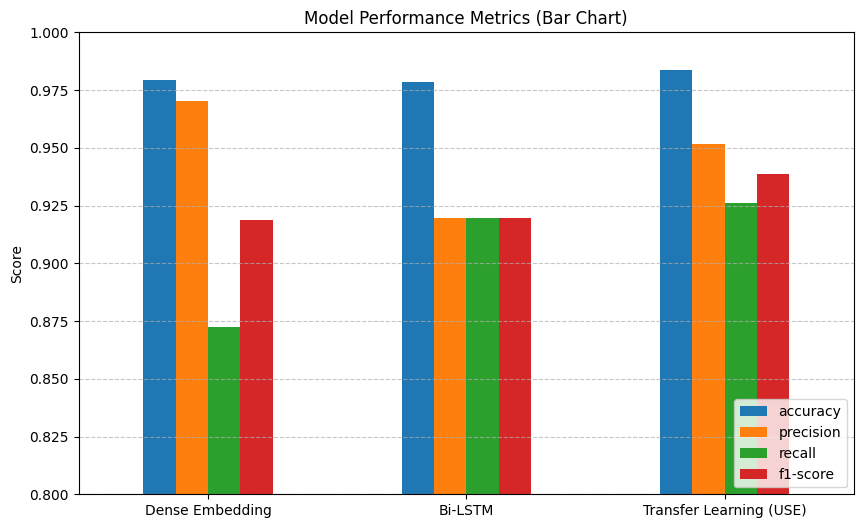

In [15]:
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Metrics (Bar Chart)")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 1


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow_hub as hub

# Step 2: Load the Dataset

In [17]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/vanha2301/dataset/versions/2/spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Step 3: Clean the dataset

In [18]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'Text'})
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Step 4: Split data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'],
    df['label_enc'],
    test_size=0.2,
    random_state=42
)
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()


# Step 5: Compute text Statistics for Vectorization

In [23]:
avg_words_len = round(sum([len(i.split())
                      for i in df['Text']]) / len(df['Text']))
total_words_length = len(set(" ".join(df['Text']).split()))

print(f"Data Loaded. Training samples: {len(X_train_np)}")
print(f"Average words per message: {avg_words_len}")
print(f"Approximate vocabulary size: {total_words_length}")

Data Loaded. Training samples: 4457
Average words per message: 16
Approximate vocabulary size: 15686


# Step 6: Helper functions for training and evaluation

In [32]:
def compile_and_fit(model, epochs=5):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train_np,
        y_train_np,
        epochs=epochs,
        validation_data=(X_test_np, y_test_np)
    )

    return history
def get_metrics(model, X, y):
    y_preds = np.round(model.predict(X))
    return {
        'accuracy': accuracy_score(y, y_preds),
        'precision': precision_score(y, y_preds),
        'recall': recall_score(y, y_preds),
        'f1-score': f1_score(y, y_preds)
    }

# Step 7: Create the TextVectorization layer

In [29]:
from tensorflow.keras.layers import TextVectorization
text_vec = TextVectorization(
    max_tokens=total_words_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=avg_words_len
)

text_vec.adapt(X_train_np)

# Step 8: Model 1

In [33]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_1 = keras.Model(input_layer, output_layer, name="Dense_Model")
history_1 = compile_and_fit(model_1)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8673 - loss: 0.3928 - val_accuracy: 0.9596 - val_loss: 0.1420
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9774 - loss: 0.0975 - val_accuracy: 0.9740 - val_loss: 0.0766
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9901 - loss: 0.0380 - val_accuracy: 0.9749 - val_loss: 0.0779
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9930 - loss: 0.0249 - val_accuracy: 0.9776 - val_loss: 0.0759
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9964 - loss: 0.0209 - val_accuracy: 0.9758 - val_loss: 0.0677
